<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_05/04_Expert_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade tensorflow tensorflow_hub tensorflow_datasets
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 MB 2.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
TF version: 2.18.1
TF Hub version: 0.16.1


In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model


In [11]:
(train_ds, val_ds), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:85%]', 'train[85%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True
)

IMG_SIZE = (224, 224)
NUM_CLASSES = ds_info.features['label'].num_classes
BATCH_SIZE = 32

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE) / 255.0
    image = data_augmentation(image)
    brightness = tf.reduce_mean(image)
    contrast = tf.image.total_variation(image)
    meta = tf.concat([tf.reshape(brightness, [1]), tf.reshape(contrast, [1])], axis=0)
    return (image, meta), label

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [12]:
def build_model():
    image_input = Input(shape=(224, 224, 3), name="image_input")
    meta_input = Input(shape=(2,), name="meta_input")  # Brightness + Contrast

    base_model = MobileNetV2(include_top=False, input_tensor=image_input, weights='imagenet')
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    x_img = GlobalAveragePooling2D()(base_model.output)
    x_img = Dense(128, activation='relu')(x_img)
    x_img = BatchNormalization()(x_img)
    x_img = Dropout(0.3)(x_img)

    x_meta = Dense(32, activation='relu')(meta_input)

    x = Concatenate()([x_img, x_meta])
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    output = Dense(NUM_CLASSES, activation='softmax')(x)

    return Model(inputs=[image_input, meta_input], outputs=output)

model = build_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


<ipython-input-12-526c6d097b63>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=image_input, weights='imagenet')


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,433,189 (9.28 MB)

 Trainable params: 1,381,029 (5.27 MB)

 Non-trainable params: 1,052,160 (4.01 MB)

In [13]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.3)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=callbacks)


Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step - accuracy: 0.2139 - loss: 327.2744 - val_accuracy: 0.4800 - val_loss: 1.6593 - learning_rate: 0.0010
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 310s 3s/step - accuracy: 0.3623 - loss: 1.3593 - val_accuracy: 0.4364 - val_loss: 1.3404 - learning_rate: 0.0010
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.2537 - loss: 1.5770 - val_accuracy: 0.4255 - val_loss: 1.3348 - learning_rate: 0.0010
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.3138 - loss: 1.4689 - val_accuracy: 0.3236 - val_loss: 1.5116 - learning_rate: 0.0010
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.2253 - loss: 1.5966 - val_accuracy: 0.3836 - val_loss: 1.4020 - learning_rate: 0.0010
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 254s 3s/step - accuracy: 0.3166 - loss: 1.4630 - val_accuracy: 0.4345 - val_loss: 1.3261 - learning_rate: 0.0010
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.3378 - loss: 1.4291 - val_a

In [15]:
# Evaluate
loss, acc = model.evaluate(val_ds)
print(f"✅ Final Validation Accuracy: {acc:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.4568 - loss: 1.2846
✅ Final Validation Accuracy: 0.4309


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


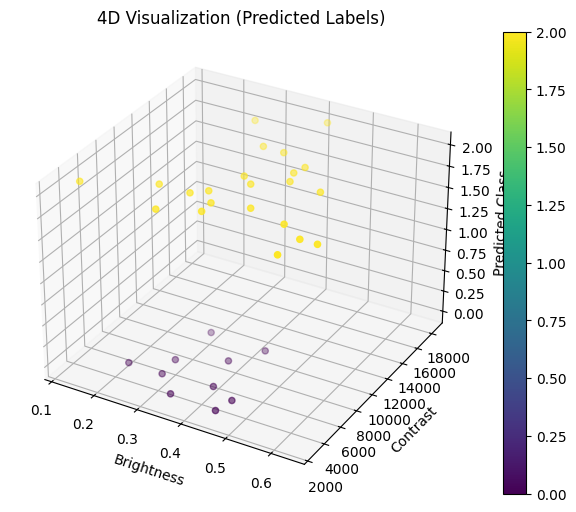

In [16]:
# 4D Scatter Plot
def plot_4d_predictions(model, dataset, title="4D Visualization (Predicted Labels)"):
    for (img_batch, meta_batch), label_batch in dataset.take(1):
        preds = model.predict([img_batch, meta_batch])
        pred_classes = np.argmax(preds, axis=1)

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(meta_batch[:, 0], meta_batch[:, 1], pred_classes,
                             c=pred_classes, cmap='viridis')
        ax.set_xlabel("Brightness")
        ax.set_ylabel("Contrast")
        ax.set_zlabel("Predicted Class")
        plt.title(title)
        plt.colorbar(scatter)
        plt.show()
        break

plot_4d_predictions(model, val_ds)

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get true labels and predictions for a batch of validation data
true_labels = []
predicted_labels = []
class_names = ds_info.features['label'].names

for (img_batch, meta_batch), labels in val_ds.take(10):  # Sample 10 batches
    preds = model.predict([img_batch, meta_batch])
    true_labels.extend(labels.numpy())
    predicted_labels.extend(np.argmax(preds, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


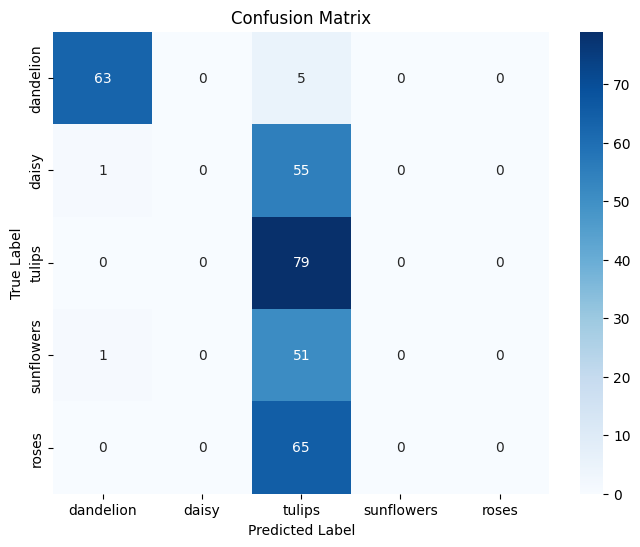

In [19]:
# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Classification Report
print("Classification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

   dandelion       0.97      0.93      0.95        68
       daisy       0.00      0.00      0.00        56
      tulips       0.31      1.00      0.47        79
  sunflowers       0.00      0.00      0.00        52
       roses       0.00      0.00      0.00        65

    accuracy                           0.44       320
   macro avg       0.26      0.39      0.28       320
weighted avg       0.28      0.44      0.32       320



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


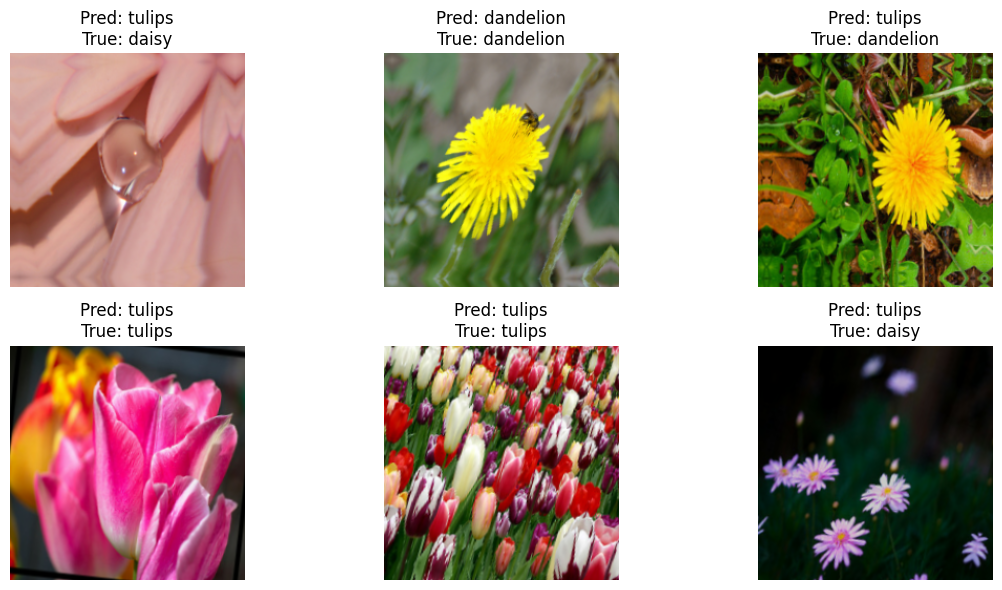

In [21]:
# Visualize some predictions
def show_image_predictions():
    for (img_batch, meta_batch), labels in val_ds.take(1):
        preds = model.predict([img_batch, meta_batch])
        pred_classes = np.argmax(preds, axis=1)

        plt.figure(figsize=(12, 6))
        for i in range(6):
            ax = plt.subplot(2, 3, i + 1)
            plt.imshow(img_batch[i].numpy())
            plt.title(f"Pred: {class_names[pred_classes[i]]}\nTrue: {class_names[labels[i]]}")
            plt.axis("off")
        plt.tight_layout()
        plt.show()

show_image_predictions()